## House price prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score,mean_squared_error, precision_score, recall_score, f1_score, confusion_matrix, r2_score
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/423BigDataAnalytics/3.14-sparkers Final project/archive/austinHousingData.csv')
df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [6]:
df.info()

## Only two values in the description column are missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15169 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

In [7]:
df.latestPrice.describe()

count    1.517100e+04
mean     5.127677e+05
std      4.531853e+05
min      5.500000e+03
25%      3.090000e+05
50%      4.050000e+05
75%      5.750000e+05
max      1.350000e+07
Name: latestPrice, dtype: float64

Analyze the distribution of some numerical features

1. Latest Price

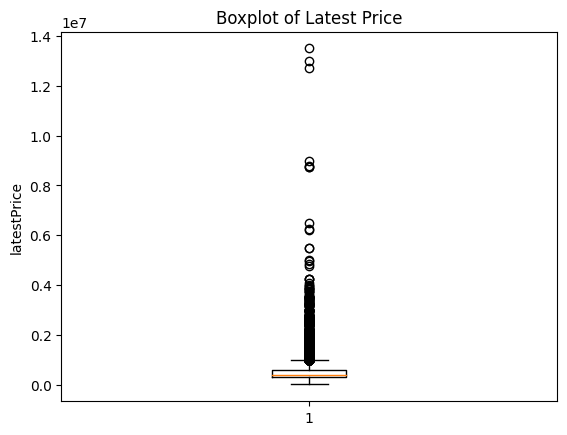

In [8]:
# Latest price
plt.boxplot(df.latestPrice)
plt.title('Boxplot of Latest Price')
plt.ylabel('latestPrice')
plt.show()

## We have a considerable amount of outliers where the sale price is very high

In [9]:
# Find the number of price outliers based on IQR
# We don't use Z-score defined outliers since the distribution is obvisouly skewed
import pandas as pd

Q1 = df['latestPrice'].quantile(0.25)
Q3 = df['latestPrice'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

low_price_outliers = len(df[df['latestPrice'] < lower_bound])
high_price_outliers = len(df[df['latestPrice'] > upper_bound])

print(f"Number of low price outliers: {low_price_outliers}")
print(f"Number of high price outliers: {high_price_outliers}")

# Calculate the proportion of outliers
print(f'Proportion of outliers using IQR method: {(low_price_outliers+high_price_outliers) / len(df)*100:.2f}%. ')

## No

Number of low price outliers: 0
Number of high price outliers: 1071
Proportion of outliers using IQR method: 7.06%. 


In [10]:
#!pip install folium

In [11]:
# Heatmap for the latest price
import folium
from folium.plugins import HeatMap

# Create a base map
m = folium.Map(location=[30.2672, -97.7431], zoom_start=10)  # Centered around Austin

# Add house price data as a heatmap
heat_data = [[row['latitude'], row['longitude'], row['latestPrice']] for index, row in df.iterrows()]
HeatMap(heat_data, radius=10).add_to(m)

# Save and display the map
m.save('austin_house_prices.html')
m

2. Price per square feet

In [12]:
# Create feature pricePerSqFt
df['pricePerSqFt'] = df.latestPrice /  df.livingAreaSqFt

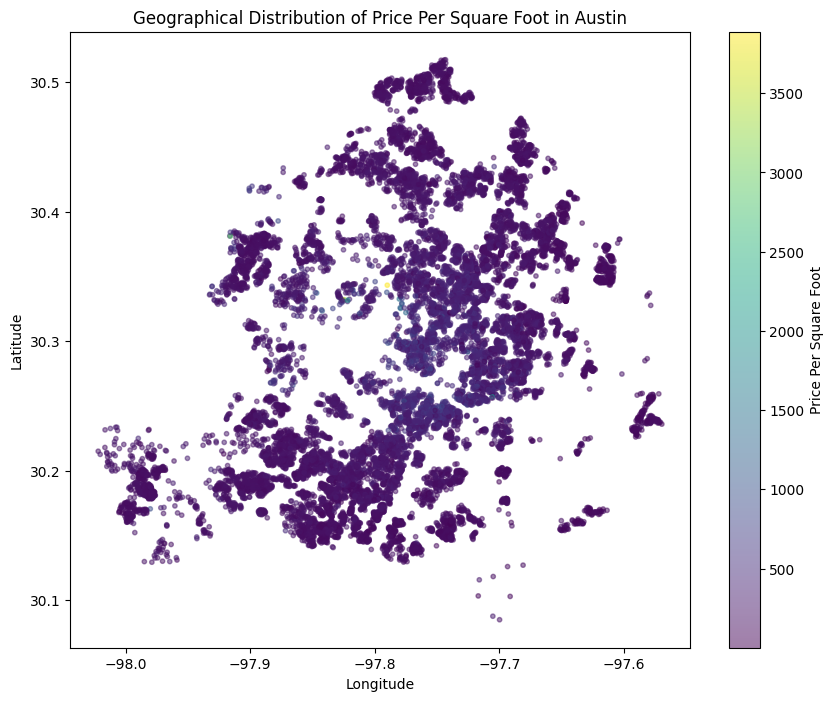

In [13]:
import matplotlib.pyplot as plt

# Plot the geographical distribution of price per square foot
plt.figure(figsize=(10, 8))
sc = plt.scatter(df['longitude'], df['latitude'], alpha=0.5,
                 c=df['pricePerSqFt'], cmap='viridis', s=10)
plt.colorbar(sc, label='Price Per Square Foot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Price Per Square Foot in Austin')
plt.show()

Examine the frequency distribution of some categorical features
1. Home Type

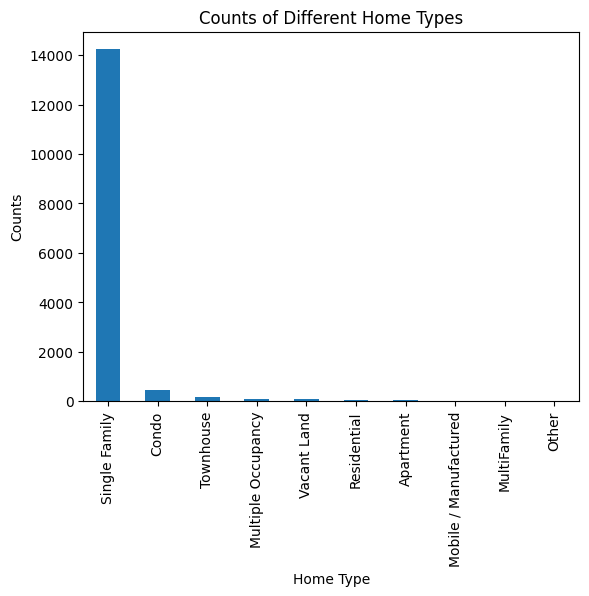

In [14]:
# Home Type
df.homeType.value_counts()
home_type_counts = df['homeType'].value_counts()

# Step 4: Create a histogram of these counts
home_type_counts.plot(kind='bar')
plt.xlabel('Home Type')
plt.ylabel('Counts')
plt.title('Counts of Different Home Types')
plt.show()
## Most homes are single family

2. Latest Sale Date

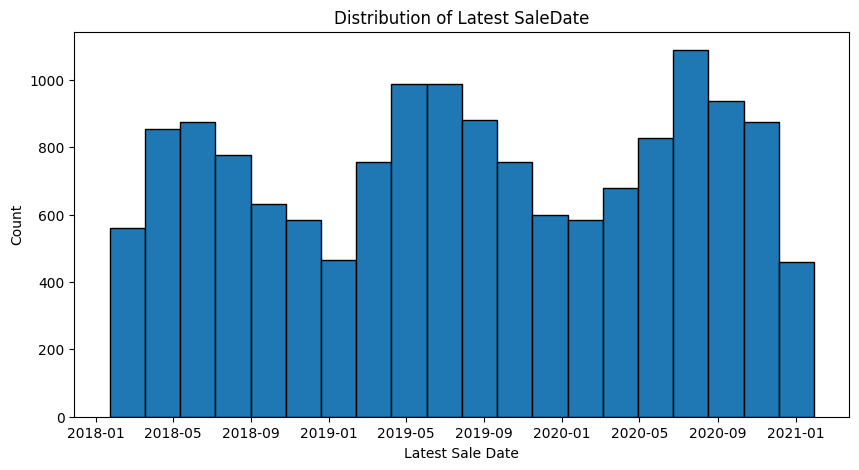

In [15]:
# Convert latest_saledate to a datatime object
df.latest_saledate =  pd.to_datetime(df.latest_saledate)

# Plot the distribution of latest_saledate
plt.figure(figsize=(10,5))
plt.hist(df.latest_saledate, bins=20, edgecolor = 'black')
plt.title('Distribution of Latest SaleDate')
plt.xlabel('Latest Sale Date')
plt.ylabel('Count')
plt.show()

## There appears to be a seasonality as well as a trend in housing sales.
## Highest sale happens usually during spring time, and decline gradually over the year
## The number of housing sales shows a slight growing trend during 2018 to 2020.

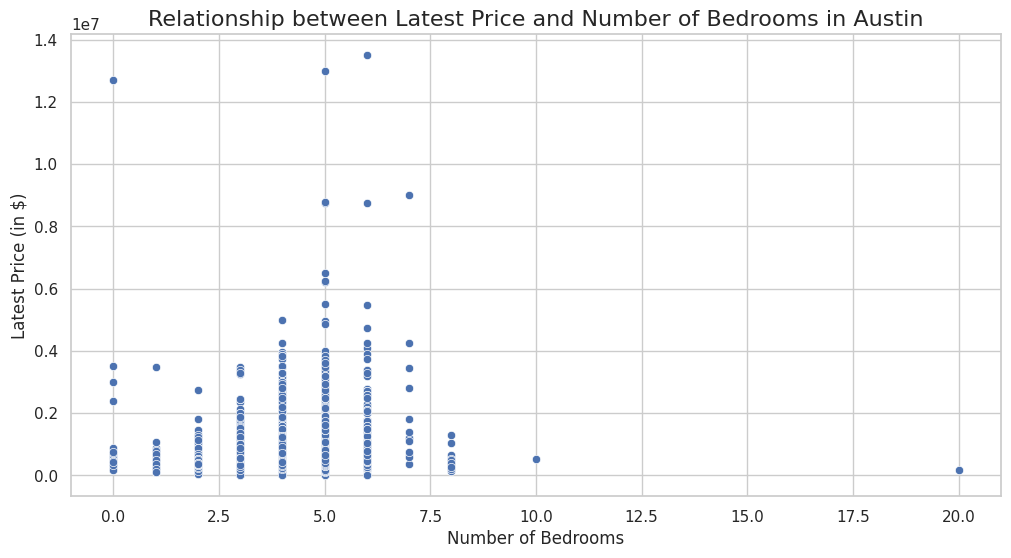

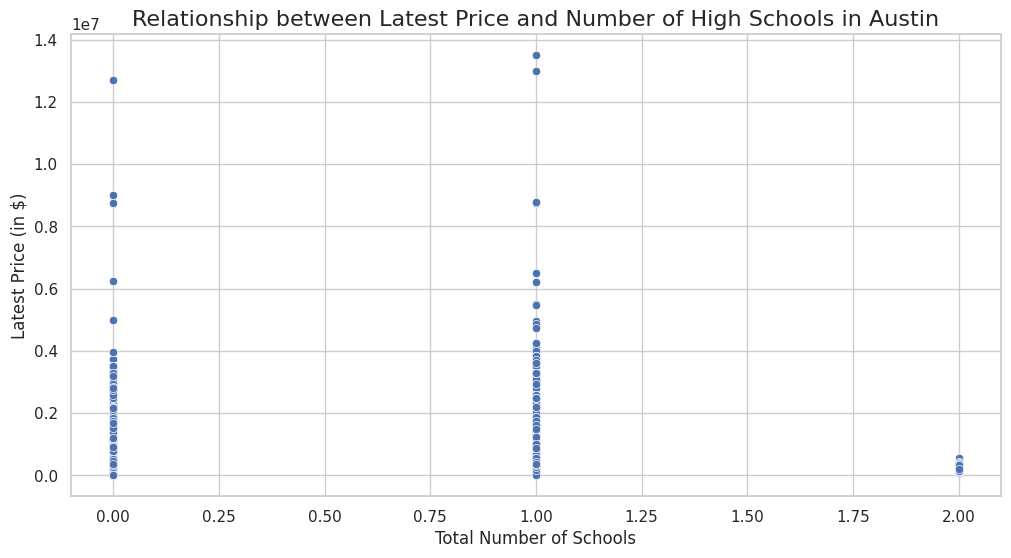

In [16]:
# Create a new column for the total number of schools
df['totalSchools'] = df['numOfElementarySchools'] + df['numOfMiddleSchools'] + df['numOfHighSchools']

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the first plot for Latest Price vs. Number of Bedrooms
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='numOfBedrooms', y='latestPrice')
plt.title('Relationship between Latest Price and Number of Bedrooms in Austin', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.ylabel('Latest Price (in $)', fontsize=12)
plt.show()

# Create the second plot for Latest Price vs. Total Number of Schools
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='numOfHighSchools', y='latestPrice')
plt.title('Relationship between Latest Price and Number of High Schools in Austin', fontsize=16)
plt.xlabel('Total Number of Schools', fontsize=12)
plt.ylabel('Latest Price (in $)', fontsize=12)
plt.show()

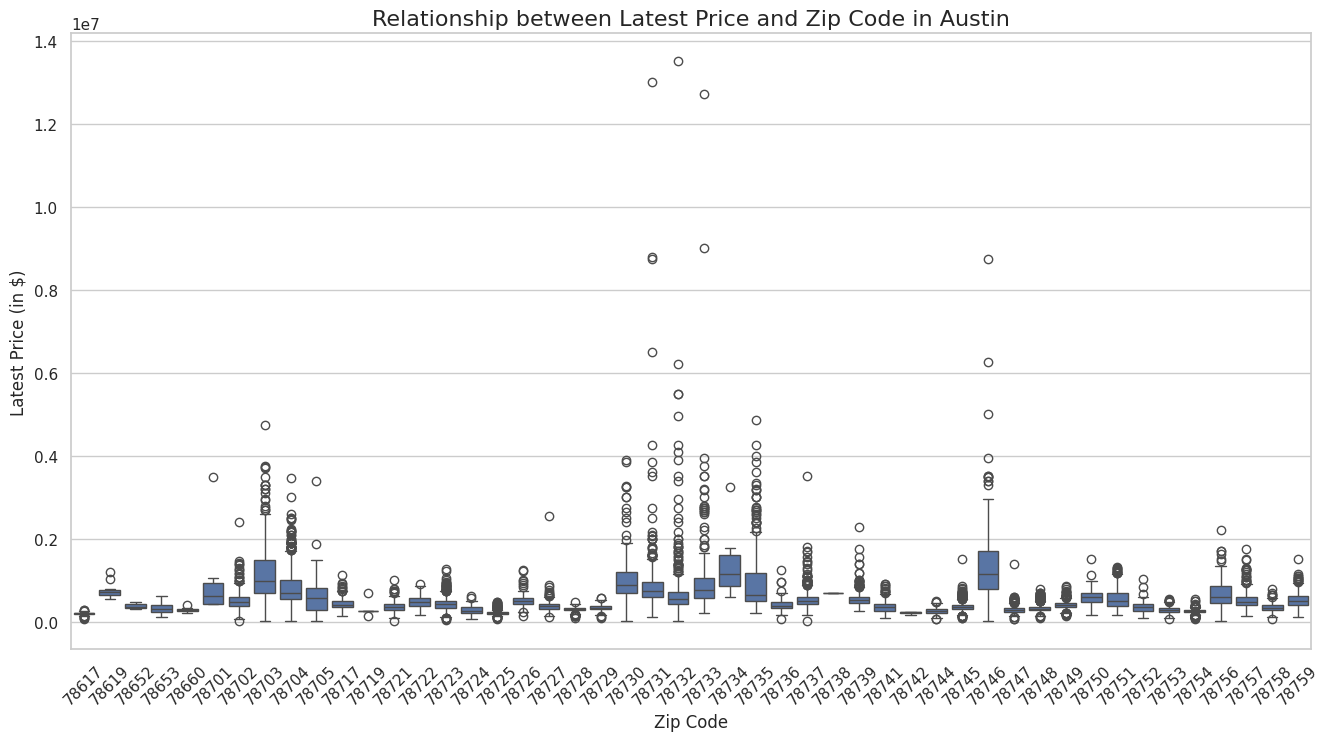

In [17]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a boxplot to visualize the relationship between Latest Price and Zip Code
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='zipcode', y='latestPrice')
plt.title('Relationship between Latest Price and Zip Code in Austin', fontsize=16)
plt.xlabel('Zip Code', fontsize=12)
plt.ylabel('Latest Price (in $)', fontsize=12)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()

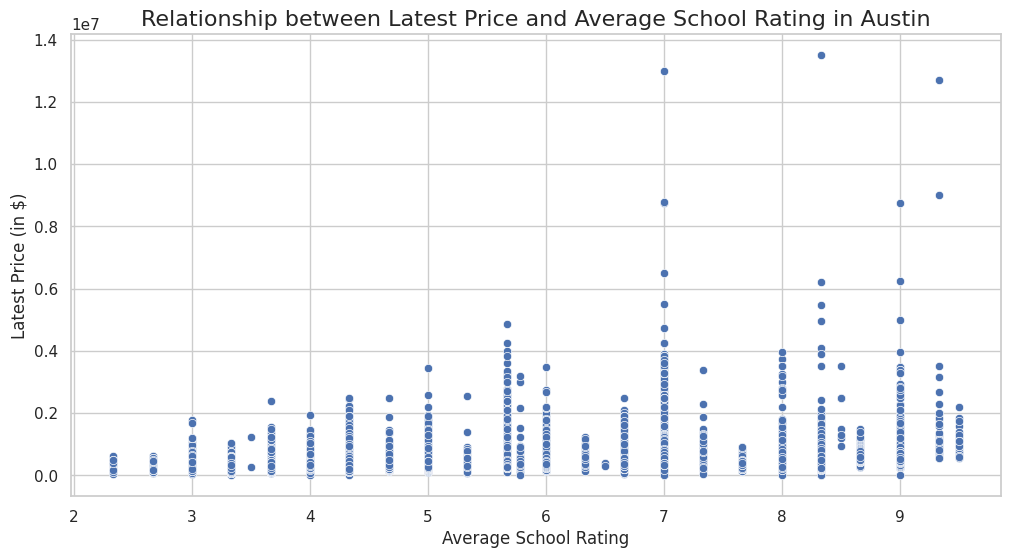

In [18]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a scatter plot to visualize the relationship between Latest Price and Average School Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='avgSchoolRating', y='latestPrice')
plt.title('Relationship between Latest Price and Average School Rating in Austin', fontsize=16)
plt.xlabel('Average School Rating', fontsize=12)
plt.ylabel('Latest Price (in $)', fontsize=12)
plt.show()

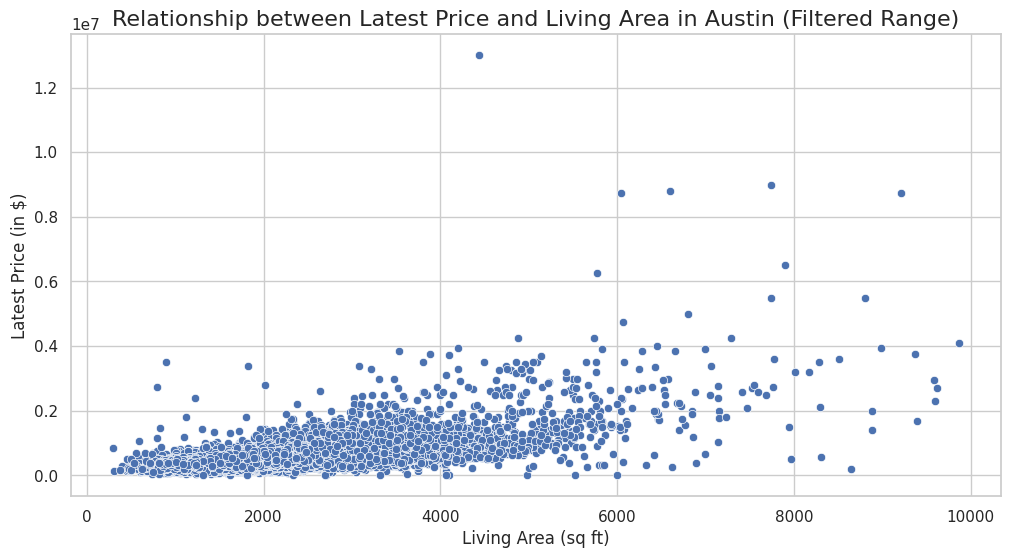

In [19]:
# Filter the data to remove extreme outliers in living area
df_filtered = df[(df['livingAreaSqFt'] > 0) & (df['livingAreaSqFt'] < 10000)]

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a scatter plot to visualize the relationship between Living Area (sq ft) and Latest Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_filtered, x='livingAreaSqFt', y='latestPrice')
plt.title('Relationship between Latest Price and Living Area in Austin (Filtered Range)', fontsize=16)
plt.xlabel('Living Area (sq ft)', fontsize=12)
plt.ylabel('Latest Price (in $)', fontsize=12)
plt.show()

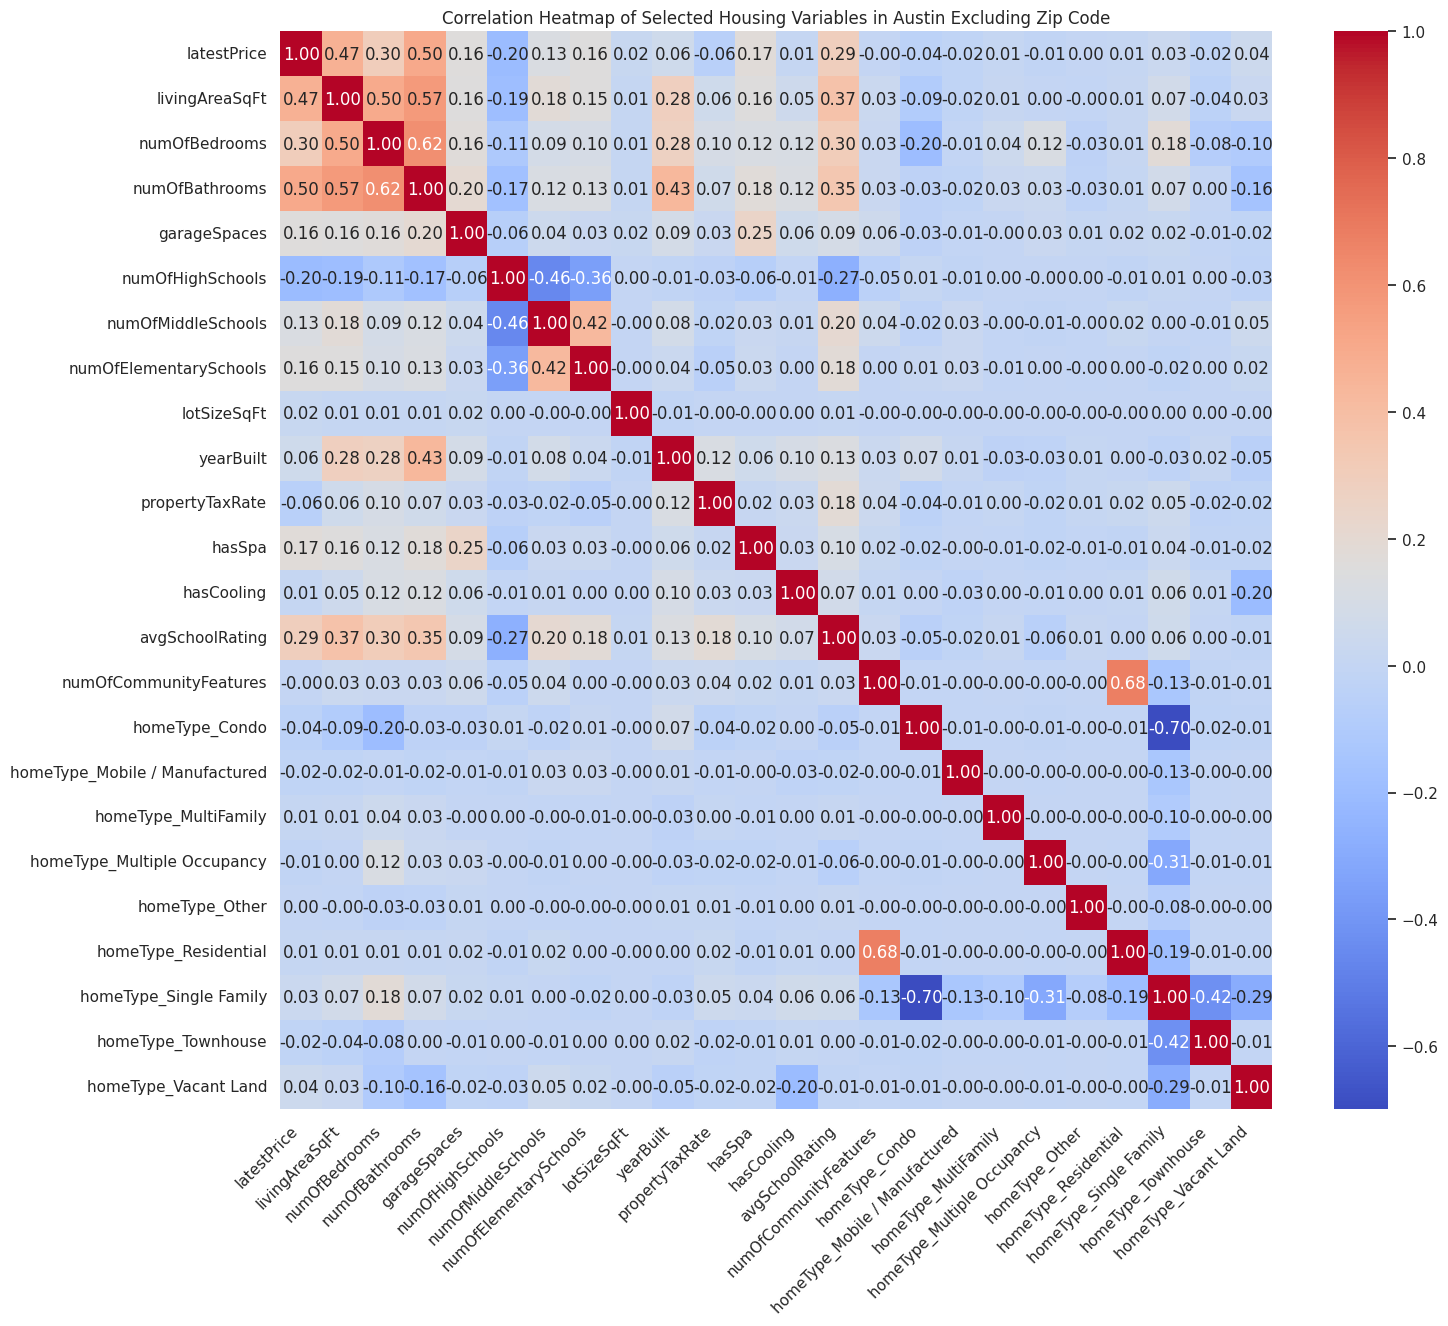

In [20]:
categorical_columns = ['hasSpa', 'hasCooling']
for column in categorical_columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: 1 if x in ['Yes', True] else 0)

# HomeType might need to be handled via one-hot encoding if it's categorical and you need to keep it
df = pd.get_dummies(df, columns=['homeType'], drop_first=True)

# List of columns for the heatmap
selected_columns = [
    'latestPrice', 'livingAreaSqFt', 'numOfBedrooms', 'numOfBathrooms',
    'garageSpaces', 'numOfHighSchools', 'numOfMiddleSchools',
    'numOfElementarySchools', 'lotSizeSqFt', 'yearBuilt', 'propertyTaxRate',
    'hasSpa', 'hasCooling', 'avgSchoolRating', 'numOfCommunityFeatures'
]

# Including the one-hot encoded 'homeType' variables except the first to avoid dummy variable trap
selected_columns += [col for col in df.columns if 'homeType' in col]

# Select the columns for the correlation matrix
df_selected = df[selected_columns]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 14))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Adjust layout for better visibility
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap of Selected Housing Variables in Austin Excluding Zip Code')
plt.show()

In [21]:
df.columns

Index(['zpid', 'city', 'streetAddress', 'zipcode', 'description', 'latitude',
       'longitude', 'propertyTaxRate', 'garageSpaces', 'hasAssociation',
       'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView',
       'parkingSpaces', 'yearBuilt', 'latestPrice', 'numPriceChanges',
       'latest_saledate', 'latest_salemonth', 'latest_saleyear',
       'latestPriceSource', 'numOfPhotos', 'numOfAccessibilityFeatures',
       'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'homeImage',
       'pricePerSqFt', 'totalSchools', 'homeType_Condo',
       'homeType_M

Predictive Modelling

# **NLP**

In [22]:
#Combining the number of schools : we are adding all the types of schools to new "number of schools" variable and dropping the individual ones
df['numOfSchools'] = df['numOfPrimarySchools'] + df['numOfElementarySchools'] + df['numOfMiddleSchools'] + df['numOfHighSchools']
df.drop(columns=['numOfPrimarySchools', 'numOfElementarySchools','numOfMiddleSchools','numOfHighSchools'], inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   zpid                            15171 non-null  int64         
 1   city                            15171 non-null  object        
 2   streetAddress                   15171 non-null  object        
 3   zipcode                         15171 non-null  int64         
 4   description                     15169 non-null  object        
 5   latitude                        15171 non-null  float64       
 6   longitude                       15171 non-null  float64       
 7   propertyTaxRate                 15171 non-null  float64       
 8   garageSpaces                    15171 non-null  int64         
 9   hasAssociation                  15171 non-null  bool          
 10  hasCooling                      15171 non-null  bool          
 11  ha

**Understanding trending words in description**

In [24]:
df['description'] = df['description'].fillna('')

# Initialize TfidfVectorizer for bi-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit and transform the description column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])

# Get feature names (bi-grams)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each feature (bi-gram)
tfidf_scores = np.sum(tfidf_matrix, axis=0).A1

# Create a DataFrame with bi-grams and their TF-IDF scores
tfidf_scores_df = pd.DataFrame({'bi-gram': feature_names, 'tfidf_score': tfidf_scores})

# Sort by TF-IDF score in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 10 bi-grams
print(tfidf_scores_df.head(15))

                    bi-gram  tfidf_score
197055                sq ft   269.499126
29217             austin tx   265.927172
95356              ft built   264.788035
108098        home contains   264.690595
58574     contains bedrooms   263.056299
228931      zestimate house   262.912542
228930       zestimate home   261.603754
176079       rent zestimate   261.603754
85043           family home   260.764875
190178        single family   258.767549
37465    bedrooms bathrooms   256.043768
34788   bathrooms zestimate   251.877010
74036             dr austin   142.718261
91559            floor plan   121.229177
63017         covered patio    92.784962


**Inference:**
Key Features:

* sq ft (269.5), ft built (264.8): Size of the property.
* home contains (264.7), contains bedrooms (263.1): Property features and number of bedrooms.
* bedrooms bathrooms (256.0): Essential metrics for listings.
Location:

* austin tx (265.9), dr austin (142.7): Geographic relevance to Austin, Texas.
Zillow Estimates:

* zestimate house/home (262.9, 261.6), rent zestimate (261.6), bathrooms
* zestimate (251.9): Importance of Zillow's property value estimates.
Property Types:

* family home (260.8), single family (258.8): Focus on family-oriented properties.

* Amenities: covered patio (92.8), floor plan (121.2): Specific property features are also significant.

In summary, the most important factors in real estate listings are property size, features, location, and value estimates, especially in Austin, TX.



Feature importance

In [25]:
df_combined=df.copy()
df_combined.drop(columns=['streetAddress','description','homeImage','latest_saledate'],inplace=True)


In [26]:
df.columns

Index(['zpid', 'city', 'streetAddress', 'zipcode', 'description', 'latitude',
       'longitude', 'propertyTaxRate', 'garageSpaces', 'hasAssociation',
       'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView',
       'parkingSpaces', 'yearBuilt', 'latestPrice', 'numPriceChanges',
       'latest_saledate', 'latest_salemonth', 'latest_saleyear',
       'latestPriceSource', 'numOfPhotos', 'numOfAccessibilityFeatures',
       'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'pricePerSqFt',
       'totalSchools', 'homeType_Condo', 'homeType_Mobile / Manufactured',
       'homeType_MultiFamily', 'homeType_Multiple Occupancy', 'homeType_Other',
  

In [27]:
# Encode categorical columns
categorical_cols = ['city','homeType_Condo', 'homeType_Mobile / Manufactured',
       'homeType_MultiFamily', 'homeType_Multiple Occupancy', 'homeType_Other',
       'homeType_Residential', 'homeType_Single Family', 'homeType_Townhouse',
       'homeType_Vacant Land', 'latestPriceSource']
for col in categorical_cols:
    df_combined[col] = LabelEncoder().fit_transform(df_combined[col])

# Example target variable (adjust as per your use case)
target = 'latestPrice'  # Change this to your target column

# Drop the target column from the features
X = df_combined.drop(columns=[target])
y = df_combined[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost
model = XGBRegressor(eval_metric='rmse')
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Display the top 10 important features
print(feature_importances_df.head(10))

                feature  importance
29       livingAreaSqFt    0.428024
37         pricePerSqFt    0.401044
21      numOfAppliances    0.040989
34       numOfBathrooms    0.021407
28          lotSizeSqFt    0.020412
4             longitude    0.018232
18    latestPriceSource    0.014297
17      latest_saleyear    0.006506
30    avgSchoolDistance    0.006078
26  numOfWindowFeatures    0.005746


**Inference:**

Most Important Features:
* livingAreaSqFt (0.428): The total square footage of the living area is the most important predictor.
* pricePerSqFt (0.401): The price per square foot is also highly significant.

Moderately Important Features:

* numOfAppliances (0.041): The number of appliances in the property.
* numOfBathrooms (0.021): The number of bathrooms available.
* lotSizeSqFt (0.020): The total size of the lot in square feet.

Less Important Features:

* longitude (0.018): The geographical longitude of the property.
* latestPriceSource (0.014): The source of the latest price data.
* latest_saleyear (0.007): The year of the latest sale.
* avgSchoolDistance (0.006): The average distance to nearby schools.
* numOfWindowFeatures (0.006): The number of window features present.

In summary, the size of the living area and the price per square foot are the most critical factors, followed by features like the number of appliances and bathrooms, and the lot size. Other features like location specifics and additional property details have lesser importance.

**XGBOOST**

In [28]:
# Selecting the top important features
selected_features = ['livingAreaSqFt','propertyTaxRate', 'numOfAppliances', 'lotSizeSqFt',
                     'numOfBathrooms', 'longitude', 'latestPriceSource', 'numOfWindowFeatures',
                     'avgSchoolDistance', 'latest_saleyear']

# Subset the data with only the selected features and the target
df_subset = df_combined[selected_features + ['latestPrice']]

# Split the data into features (X) and target (y)
X = df_subset.drop(columns=['latestPrice'])
y = df_subset['latestPrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost with the selected features
model = XGBRegressor(eval_metric='rmse')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 111188544455.05887
R-squared Score: 0.5302043954864011


**INFERENCE:** R-squared score measures the proportion of variance in the target variable (house prices) that is predictable from the selected features. An R2 score of 0.5302 indicates that approximately 53% of the variance in house prices can be explained by the selected features, which is relatively good

In [29]:
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np

# Selecting the top important features
selected_features = ['livingAreaSqFt','propertyTaxRate', 'numOfAppliances', 'lotSizeSqFt',
                     'numOfBathrooms', 'longitude', 'latestPriceSource', 'numOfWindowFeatures',
                     'avgSchoolDistance', 'latest_saleyear']

# Subset the data with only the selected features and the target
df_subset = df_combined[selected_features + ['latestPrice']]

# Split the data into features (X) and target (y)
X = df_subset.drop(columns=['latestPrice'])
y = df_subset['latestPrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost with the selected features
model = XGBRegressor(eval_metric='rmse')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Define a threshold to convert predictions to binary classes
threshold = y_test.mean()  # Example threshold

# Convert the continuous predictions into binary classes
y_pred_binary = (y_pred >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)

# Calculate precision and recall
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Mean Squared Error: 111188544455.05887
R-squared Score: 0.5302043954864011
Precision: 0.7736040609137056
Recall: 0.7929240374609782


Performance Metrics:
Precision: 0.7736 – About 77.36% of the houses predicted to be above the threshold (e.g., mean house price) were actually above it.
Recall: 0.7929 – Approximately 79.29% of the houses actually above the threshold were correctly identified by the model.
Interpretation and Impact:
Precision: High precision indicates the model rarely overestimates house prices, ensuring reliable predictions for higher-value properties.
Recall: High recall means the model effectively identifies most houses that are above the price threshold, minimizing missed investment opportunities.
The combination of high precision and recall makes this model a valuable tool for real estate investors, providing reliable insights for making informed investment decisions, optimizing portfolios, and maximizing returns. This drives profitability and growth in the real estate sector.

